# Visual Odometry for KITTI Dataset

Implementation of VO

## Modules


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import scipy.signal
import scipy.linalg
import mae6292.tools as mae6292
import importlib

from mae6292.imshow import cv2_imshow

## Boostrapping

Bootstrapping to initilize VO has been implemented by
```
keypoints0, p_W0, R1, T1 = mae6292.VO_bootstrap(img0, img1, K, param, display = False)   
```

(376, 1241)
N_keypoints0= 728


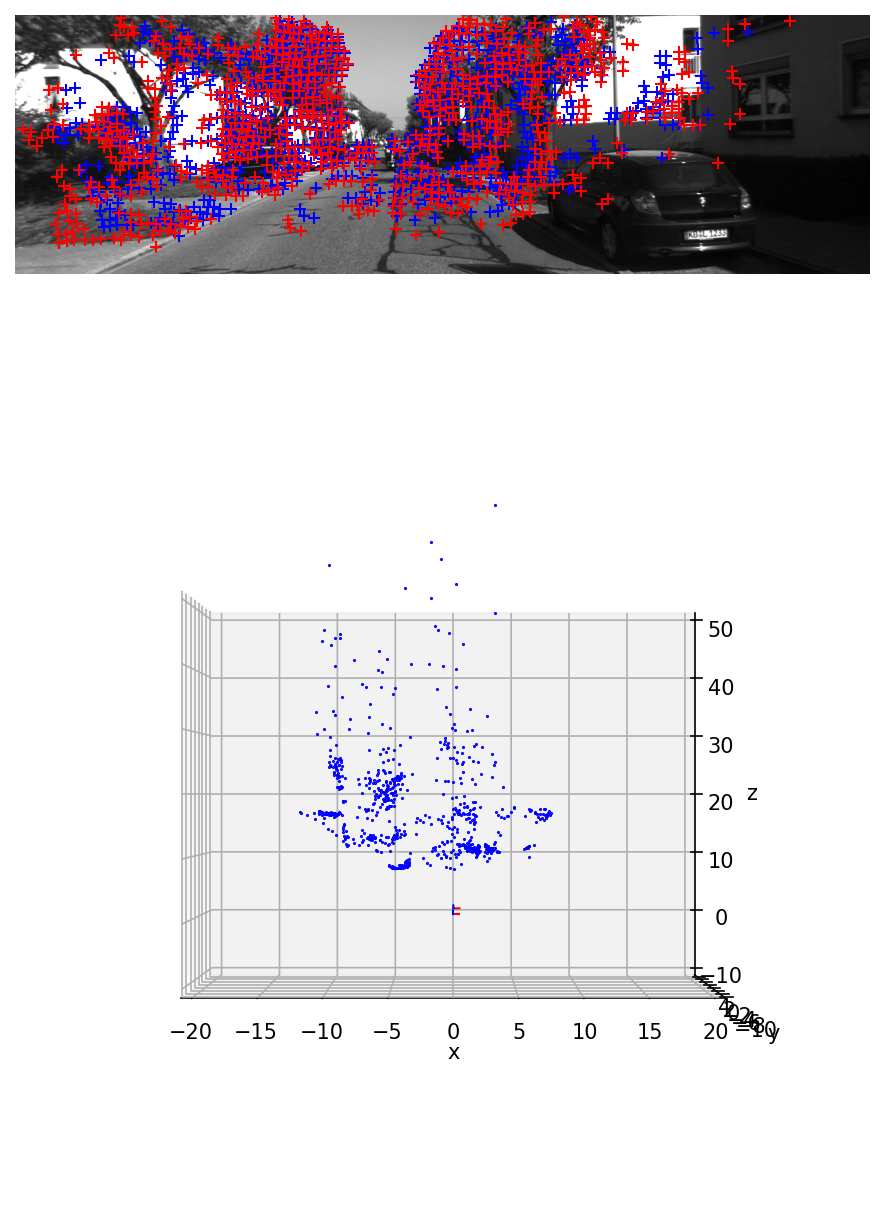

In [2]:
# !jupyter nbconvert --to script VO - KITTI.ipynb
importlib.reload(mae6292)

K = np.loadtxt('data/K.txt')
img0 = cv2.imread('data/000000.png', cv2.IMREAD_GRAYSCALE)
print(img0.shape)
img1 = cv2.imread('data/000002.png', cv2.IMREAD_GRAYSCALE)

# PARAMETERS
param_bootstrap = {
    # keypoints
    'W_harris_patch' : 4, # size of harris patch
    'kappa_harris' : 0.08, # kappa for harris score
    'N_keypoint' : 2000, # number of keypoints to be detected
    'W_nms' : 8, # patch size for non-maximum supression
    # KLT
    'W_KLT' : 4, # patch size for KLT
    'tol_KLT_bidir' : 1, # tolerence of bidirectional error
    # find essential matrix
    'tol_E' : 1, # tolerence for epipolar line distance
    'tol_E_RANSAC_prob' : 0.99, # eseential matrix RANSAC probability
    # triangulation
    'tol_TRI_mu' : 1e-3, # tolerence for the singular value ratio
    'tol_TRI_rep' : 1, # tolerence for the reprojection error
    'tol_TRI_depth' : (1, 100) # min depth and max depth for triangulation
}

keypoints0, p_W0, R1, T1 = mae6292.VO_bootstrap(img0, img1, K, param_bootstrap, display = True)   
scale = 0.693071855459021
T1 = T1*scale
p_W0 = p_W0*scale

print('N_keypoints0=',len(keypoints0))


## Localization and Mapping


The sequential process for localization and mapping has been implemented by
```
    R, T, S, C, fig = mae6292.VO_localization_mapping(i_frame, K, img, img_pre, S_pre, C_pre, display_process=True)
```
Each frame is saved under the folder `output`

In [3]:
#open a new window for plot
# %matplotlib tk
%matplotlib notebook
importlib.reload(mae6292)

# PARAMETERS
param = {
    # keypoints
    'W_harris_patch' : 4, # size of harris patch
    'kappa_harris' : 0.08, # kappa for harris score
    'N_keypoint' : 2000, # number of keypoints to be detected
    'W_nms' : 8, # patch size for non-maximum supression
    # KLT
    'W_KLT' : 4, # patch size for KLT
    'tol_KLT_bidir' : 1, # tolerence of bidirectional error
    # triangulation
    'tol_TRI_mu' : 1e-3, # tolerence for the singular value ratio
    'tol_TRI_rep' : 0.5, # tolerence for the reprojection error
    'tol_TRI_depth' : (1, 100), # min depth and max depth for triangulation
    # mapping
    'tol_keypoints_new' : 18 # new keypoints should be district from the tracked keypoints by this distance
} # up to 1000 


# iniitlize iteration
img_pre = img0
S_pre = mae6292.state(keypoints0, p_W0, [np.zeros((3,1))])
C_pre = mae6292.candidate([],[],[],[])

# number of frames to process
N_frames = 30
display_process = True

# varialbes to save the vehicle location and the keypoints in the W-frame 
T_W = np.zeros((3,N_frames+1))
p_W = p_W0


for i_frame in range(1,N_frames+1):
    
    print('i_frame=',i_frame)

    # VO localization and mapping
    img = cv2.imread("data/{:06d}.png".format(i_frame),cv2.IMREAD_GRAYSCALE)
    img_rgb = cv2.imread("data/{:06d}.png".format(i_frame),cv2.IMREAD_COLOR)
    R, T, S, C, fig = mae6292.VO_localization_mapping(i_frame, img, img_rgb, img_pre, S_pre, C_pre, K, param, display_process = True)
    img_pre, S_pre, C_pre = img, S, C

    # save figure 
    if display_process:
        fig.savefig("output/{:06d}.png".format(i_frame))
        plt.close(fig)

    # save the vehicle location and the distinct keypoints 
    T_W[:,i_frame] = (-R.T@T).flatten()
    p_W_dist = scipy.spatial.distance.cdist( S.p_W.T, p_W.T , 'euclidean')
    index_distinct = np.where( np.min(p_W_dist, axis=1) > 3 )[0]
    p_W = np.append(p_W, S.p_W[:,index_distinct], axis=1)

    # print pose
    print('R=',R)
    print('T_W=',(-R.T@T).flatten())
    print(' ')




i_frame= 1


TypeError: VO_localization_mapping() missing 1 required positional argument: 'param'

The following codes visualize the vehicle trajectory and the keypoints in the W-frame. 

(You may need to adjust th eaxis limit)

In [ ]:


%matplotlib inline
fig = plt.figure(dpi=150,figsize=(5,8))
ax = plt.axes(projection = '3d')
ax.plot(T_W[0,:], T_W[1,:], T_W[2,:], 'r', linewidth=1)
ax.scatter(p_W[0,:], p_W[1,:], p_W[2,:], s=0.1, c='b', marker='o')
ax.set_xlim(-150,100)
ax.set_zlim(-10,370)
ax.set_ylim(-50,50)
ax.set_xlabel('x',fontsize=6)
ax.set_ylabel('y',fontsize=6)
ax.set_zlabel('z',fontsize=6)
ax.view_init(elev=0., azim=-90)

In [ ]:
print(np.min(T_W, axis=1))
print(np.max(T_W, axis=1))


### Video

The output images can be converted into a video as follows.

In [ ]:
img_array = []

for i_frame in range(1,N_frames):
    filename = "output/{:06d}.png".format(i_frame)
    img = cv2.imread(filename)
    img_array.append(img)

height, width, layers = img.shape
size = (width,height)

fps = 6
codec = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4',codec, fps, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])

out.release()